# Options Analysis - Deribit BTC 

This notebook serves as a basis for building options strategies on Deribit BTC. I noticed that IVs spread was extremely high at a glance. This inspired me to continue further exploring this dataset, as well as to develop my understanding surrounding options.

I assume that BTC Options generally follow the structure of a FX option. However, I do not know the nature of a FX option.

Data:
1. Deribit Option Orderbook
   1. Interval: 15min
   2. Duration: 011124 00:00 - 301124 23:45
2. Binance Spot
   1. Interval: 15min
   2. Duration 010624 00:00 - 123124 23:45

## Data Processing

In [1]:
import sys
import os

root_dir = os.path.abspath("/Users/ryant/Documents/Github/digital-asset-options-pricing")
if root_dir not in sys.path:
    sys.path.append(root_dir)
os.chdir(root_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [105]:
df_orderbook = pd.read_parquet('./src/data/deribit/data/deribit_btc_snapshot_011124_301124.parquet')
df_orderbook = df_orderbook.drop(columns = ['volume', 'mark_price', 'volume', 'bid_iv', 'ask_iv'])
df_orderbook.describe()

,date,open_interest,mark_iv,strike,best_bid_price,best_ask_price,underlyer_spot,forward_price,best_ask_amount,best_bid_amount
count,2.455858e+06,2.455858e+06,2.455858e+06,2.455858e+06,2.455858e+06,2.455858e+06,2.455858e+06,2.455858e+06,2.455858e+06,2.455858e+06
mean,1.731723e+12,3.682273e+02,7.453664e+01,8.750852e+04,1.337265e-01,1.462846e-01,8.650073e+04,8.847627e+04,1.507424e+01,1.647897e+01
std,7.427634e+08,8.495688e+02,2.934203e+01,4.289168e+04,2.158011e-01,2.871989e-01,1.038771e+04,1.112635e+04,1.819353e+01,2.133846e+01
min,1.730419e+12,0.000000e+00,1.559000e+01,1.000000e+04,0.000000e+00,0.000000e+00,6.691202e+04,6.692697e+04,0.000000e+00,0.000000e+00
25%,1.731095e+12,6.500000e+00,5.770000e+01,6.400000e+04,1.900000e-03,2.300000e-03,7.634593e+04,7.747065e+04,3.400000e+00,3.000000e+00
50%,1.731716e+12,7.490000e+01,6.423000e+01,8.100000e+04,3.550000e-02,3.800000e-02,9.048028e+04,9.168601e+04,1.020000e+01,1.070000e+01
75%,1.732363e+12,3.424000e+02,8.026000e+01,1.000000e+05,1.770000e-01,1.985000e-01,9.541185e+04,9.752491e+04,1.890000e+01,2.030000e+01
max,1.733010e+12,1.048990e+04,2.772900e+02,3.000000e+05,2.377000e+00,1.500000e+01,9.952804e+04,1.102023e+05,3.105000e+02,1.005000e+03


In [78]:
df_options = df_orderbook.groupby(['instrument_name']).agg({'expiration_date': 'first'}).reset_index()
df_options['expiration'] = pd.to_datetime(df_options['expiration_date'], utc=True)
df_options['expiration_date'] = df_options['expiration'].dt.date
# Extract day of week for expiration (0=Monday, 6=Sunday)
df_options['expiry_dow'] = df_options['expiration'].dt.dayofweek  # 4 = Friday

# Determine if it's the last Friday of the month
# Get the last day of each expiration month
# df_options['last_day_of_month'] = df_options['expiration_date'].dt.to_period('M').dt.to_timestamp('M')
# # Move backward to find the last Friday (weekday 4)
# df_options['last_friday'] = df_options.apply(
#     lambda x: x['last_day_of_month'] - pd.Timedelta(days=((x['last_day_of_month'].dayofweek - 4) % 7)), 
#     axis=1
# )

def get_last_friday(date):
    return (pd.Timestamp(date.year + (date.month // 12), ((date.month % 12) + 1), 1) - pd.Timedelta(days=1) - pd.Timedelta(days=((pd.Timestamp(date.year + (date.month // 12), ((date.month % 12) + 1), 1) - pd.Timedelta(days=1)).weekday() - 4) % 7))

df_options['last_friday'] = df_options['expiration'].apply(get_last_friday)

# Determine the month number for quarterly calculation (1=Jan, 2=Feb, etc.)
df_options['expiry_month'] = df_options['expiration'].dt.month

# Create the classification columns
# Daily options: expire every day at 08:00 UTC
def classify_option(row):
    expiration_date = row['expiration']
    expiry_dow = row['expiry_dow']
    last_friday = row['last_friday']
    expiry_month = row['expiry_month']

    is_same_date = expiration_date.date() == last_friday.date()

    is_quarterly = is_same_date and expiry_month in [3, 6, 9, 12]
    is_monthly = is_same_date and expiry_month not in [3, 6, 9, 12]
    is_weekly = expiry_dow == 4 and not is_same_date
    is_daily = expiry_dow != 4 and expiration_date != last_friday
    
    if is_quarterly:
        return 4
    elif is_monthly:
        return 3
    elif is_weekly:
        return 2
    elif is_daily:
        return 1
    else:
        return 0

df_options['option_type'] = df_options.apply(lambda x: classify_option(x), axis=1)
df_options

,instrument_name,expiration_date,expiration,expiry_dow,last_friday,expiry_month,option_type
0,BTC-10NOV24-66000-C,2024-11-10,2024-11-10 08:00:00+00:00,6,2024-11-29,11,1
1,BTC-10NOV24-66000-P,2024-11-10,2024-11-10 08:00:00+00:00,6,2024-11-29,11,1
2,BTC-10NOV24-67000-C,2024-11-10,2024-11-10 08:00:00+00:00,6,2024-11-29,11,1
3,BTC-10NOV24-67000-P,2024-11-10,2024-11-10 08:00:00+00:00,6,2024-11-29,11,1
4,BTC-10NOV24-68000-C,2024-11-10,2024-11-10 08:00:00+00:00,6,2024-11-29,11,1
...,...,...,...,...,...,...,...
2993,BTC-9NOV24-86000-P,2024-11-09,2024-11-09 08:00:00+00:00,5,2024-11-29,11,1
2994,BTC-9NOV24-87000-C,2024-11-09,2024-11-09 08:00:00+00:00,5,2024-11-29,11,1
2995,BTC-9NOV24-87000-P,2024-11-09,2024-11-09 08:00:00+00:00,5,2024-11-29,11,1
2996,BTC-9NOV24-88000-C,2024-11-09,2024-11-09 08:00:00+00:00,5,2024-11-29,11,1


In [81]:
df_options['option_type'].value_counts()

option_type
1    1744
2     570
3     346
4     338
Name: count, dtype: int64

# Data Analysis

## Open Interest

- Call Option OI significantly higher than Put OI. Is there a reason why it is like that?

In [100]:
orderbook_oi = df_orderbook.groupby(['date', 'strike', 'claim_type']).agg({'open_interest' : 'sum'}).reset_index()
orderbook_oi['date'] = pd.to_datetime(orderbook_oi['date'], unit = 'ms')
orderbook_oi.head(5)

,date,strike,claim_type,open_interest
0,2024-11-01,10000,call,38.6
1,2024-11-01,10000,put,519.8
2,2024-11-01,15000,call,8.2
3,2024-11-01,15000,put,303.5
4,2024-11-01,20000,call,197.8


In [106]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, widgets

# Assuming your data is in a DataFrame called 'df' with columns:
# 'date', 'strike', 'claim_type', 'open_interest'

# If you need to load your data from a file, uncomment and adjust the following:
# df = pd.read_csv('your_options_data.csv')
# df['date'] = pd.to_datetime(df['date'])  # Convert to datetime if not already

def plot_open_interest(df):
    # Get unique dates for our slider
    dates = sorted(df['date'].unique())
    
    # Create a function to plot open interest for a specific date
    def plot_for_date(selected_date):
        # Filter data for the selected date
        filtered_data = df[df['date'] == selected_date]
        
        # Create a figure with two subplots (calls and puts)
        fig = make_subplots(rows=2, cols=1, 
                           subplot_titles=('Call Options Open Interest', 'Put Options Open Interest'),
                           shared_xaxes=True,
                           vertical_spacing=0.1)
        
        # Plot calls
        calls_data = filtered_data[filtered_data['claim_type'] == 'call']
        if not calls_data.empty:
            fig.add_trace(
                go.Bar(
                    x=calls_data['strike'],
                    y=calls_data['open_interest'],
                    name='Calls',
                    marker_color='blue'
                ),
                row=1, col=1
            )
        
        # Plot puts
        puts_data = filtered_data[filtered_data['claim_type'] == 'put']
        if not puts_data.empty:
            fig.add_trace(
                go.Bar(
                    x=puts_data['strike'],
                    y=puts_data['open_interest'],
                    name='Puts',
                    marker_color='red'
                ),
                row=2, col=1
            )
        
        # Update layout
        fig.update_layout(
            title=f'Options Open Interest for {selected_date}',
            xaxis_title='Strike Price',
            yaxis_title='Open Interest',
            height=800,
            width=1000,
            showlegend=False
        )
        
        fig.show()
    
    # Create an interactive widget for date selection
    date_picker = widgets.Select(
        options=dates,
        value=dates[0],
        description='Date:',
        disabled=False
    )
    
    # Create the interactive visualization
    interact(plot_for_date, selected_date=date_picker)

# Alternative implementation using a slider if you have many dates
def plot_open_interest_slider(df):
    # Get unique dates and convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    dates = sorted(df['date'].unique())
    
    # Create a slider index instead of direct date selection
    def plot_for_index(date_index):
        selected_date = dates[date_index]
        
        # Filter data for the selected date
        filtered_data = df[df['date'] == selected_date]
        
        # Create figure
        fig = px.bar(
            filtered_data, 
            x='strike', 
            y='open_interest',
            color='claim_type',
            title=f'Options Open Interest for {selected_date.strftime("%Y-%m-%d")}',
            color_discrete_map={'call': 'blue', 'put': 'red'},
            barmode='group'
        )
        
        fig.update_layout(
            xaxis_title='Strike Price',
            yaxis_title='Open Interest',
            legend_title='Option Type'
        )
        
        fig.show()
    
    # Create slider widget
    date_slider = widgets.IntSlider(
        min=0,
        max=len(dates)-1,
        step=1,
        value=0,
        description='Date Index:',
        continuous_update=False
    )
    
    # Create the interactive visualization with slider
    interact(plot_for_index, date_index=date_slider)

# Example usage:
# plot_open_interest(orderbook_oi)         # Using date selector
# plot_open_interest_slider(orderbook_oi)  # Using slider

In [ ]:
orderbook_oi_time = orderbook_oi.groupby(['date', 'claim_type']).agg({'open_interest' : 'sum'}).reset_index()
orderbook_oi_time

,date,claim_type,open_interest
0,2024-11-01 00:00:00,call,186209.5
1,2024-11-01 00:00:00,put,95721.4
2,2024-11-01 00:15:00,call,186150.1
3,2024-11-01 00:15:00,put,95730.2
4,2024-11-01 00:30:00,call,186175.6
...,...,...,...
5619,2024-11-30 23:15:00,put,97408.0
5620,2024-11-30 23:30:00,call,189920.9
5621,2024-11-30 23:30:00,put,97424.1
5622,2024-11-30 23:45:00,call,190000.6


<Axes: title={'center': 'Open Interest Over Time'}, xlabel='date'>

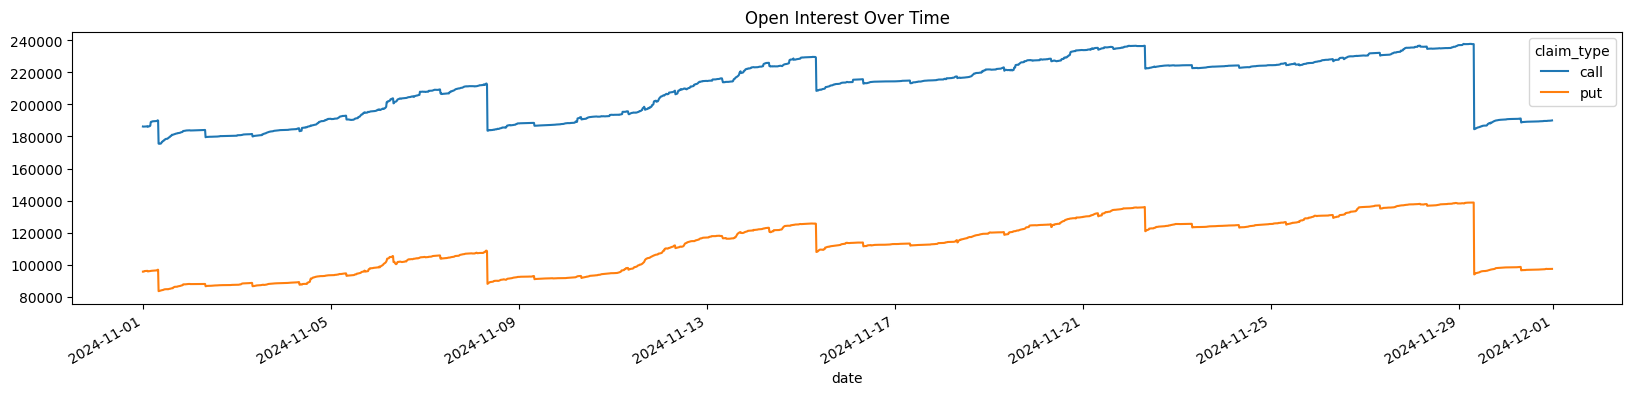

In [117]:
orderbook_oi.groupby(['date', 'claim_type']).agg({'open_interest' : 'sum'}).reset_index().pivot(index = 'date', columns = 'claim_type', values = 'open_interest').plot(title = 'Open Interest Over Time', figsize=(20, 4))